In [19]:
import numpy as np
import cv2 as cv
import pickle
import scipy.io as io
from scipy.signal import get_window
import numpy.matlib as matlib
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
import glob

In [20]:
# function alias starts
sin = np.sin
cos = np.cos
atan = np.arctan
fft = np.fft.fft
ifft = np.fft.ifft
fftshift = np.fft.fftshift
ifftshift = np.fft.ifftshift
sinc = np.sinc
sqrt = np.sqrt
real = np.real
pi = np.pi

## Data cleaning for real data

In [22]:
I0 = 50
img = []
image = {}
data = io.loadmat("lab6_data/sinogram.mat")
# with open(r"lab6_data/phantom_2_exp4_1_angle_filt_no_0168.json", "rb") as input_file:
#     data1 = pickle.load(input_file)
# with open(r"lab6_data/phantom_2_exp4_1_angle_filt_no210360.json", "rb") as input_file:
#     data2 = pickle.load(input_file)
# image = data1 | data2
# data = np.zeros((1280, 360))

# for i in range(0,360):
#     img = np.mean(image[i], axis = 0)
#     val = img[512, 0:1280]
#     data[:, i] = val

In [25]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SAD', 'pixelsize', 'y'])

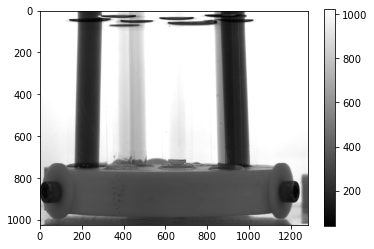

In [18]:
plt.imshow(np.mean(image[20], axis = 0), cmap = 'gray')
plt.colorbar()
plt.show()

In [26]:
y = data['y'] #for sinogram
# y = data #for original data
size = y.shape
minus1 = np.multiply(-1, np.ones(y.shape))
rec = -1 * np.log(np.divide(y, I0)) 
rec.shape

(2330, 360)

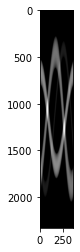

In [27]:
plt.imshow(rec, cmap = 'gray')
plt.show()

# GitHub Repo

In [29]:
def cart2pol(x, y):
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return (phi, rho)

In [54]:
def Filter(N, pixel_size, FilterType, cutoff):
    '''
    TO DO: Ram-Lak filter implementation
               Argument for name of filter
    '''
    try:
        if cutoff > 0.5 or cutoff < 0:
            raise ErrorDescription(4)
    except ErrorDescription as e:
        print(e)
    x = np.arange(0, N) - (N - 1) / 2
    h = np.zeros(len(x))
    h[np.where(x == 0)] = 1 / (8 * pixel_size ** 2)
    odds = np.where(x % 2 == 1)
    h[odds] = -0.5 / (pi * pixel_size * x[odds]) ** 2
    h = h[0:-1]
    filter = abs(fftshift(fft(h))) * 2
    w = 2 * pi * x[0:-1] / (N - 1)
    print(filter.shape, w.shape)
    if FilterType == 'ram-lak':
        pass  # Do nothing
    elif FilterType == 'shepp-logan':
        zero = np.where(w == 0)
        tmp = filter[zero]
        filter = filter * sin(w / (2 * cutoff)) / (w / (2 * cutoff))
        filter[zero] = tmp * sin(w[zero] / (2 * cutoff))
    elif FilterType == 'cosine':
        filter = filter * cos(w / (2 * cutoff))
    elif FilterType == 'hamming':
        filter = filter * (0.54 + 0.46 * (cos(w / cutoff)))
    elif FilterType == 'hann':
        filter = filter * (0.5 + 0.5 * cos(w / cutoff))

    filter[np.where(abs(w) > pi * cutoff)] = 0
    return filter

In [ ]:
def Reconstruction(self, savefile):
    R = self.params['SourceToAxis']
    D = self.params['SourceToDetector'] - R
    nx = int(self.params['DetectorWidth'])
    ny = int(self.params['DetectorHeight'])
    ns = int(self.params['NumberOfViews'])
    DetectorPixelWidth = self.params['DetectorPixelWidth']
    ZeroPaddedLength = int(2 ** (ceil(log2(2 * (nx - 1)))))
#         DetectorPixelWidth = 445.059 / nx;
    print(DetectorPixelWidth)
    recon = np.zeros(self.recon.shape)
    DetectorSize = nx * DetectorPixelWidth
    fov = 2 * R * sin(atan(DetectorSize / 2 / (D + R)))
    self.params['fov'] = fov
    x = np.linspace(-fov / 2, fov / 2, self.params['ReconX'])
    y = np.linspace(-fov / 2, fov / 2, self.params['ReconY'])
    [xx, yy] = np.meshgrid(x, y)
    [phi, rho] = FanBeam.cart2pol(xx, yy)
    ReconZ = self.recon.shape[2]
    ProjectionAngle = np.linspace(0, self.params['AngleCoverage'], ns + 1)
    ProjectionAngle = ProjectionAngle[0:-1]
    dtheta = ProjectionAngle[1] - ProjectionAngle[0]
    assert(len(ProjectionAngle == ns))
    print('Reconstruction starts')
    cutoff = 0.3
    FilterType = 'hann'
    filter = FanBeam.Filter(
        ZeroPaddedLength + 1, DetectorPixelWidth * (R / (R + D)), FilterType, cutoff)
    gamma = np.arange(0, nx) - (nx - 1) / 2.0
    gamma = gamma * DetectorPixelWidth * (R / (R + D))
#         for j in range(0, ny):
    for j in range(0, ny):
        sino = self.sino[:, :, j]
        weight = R / (sqrt(R ** 2 + gamma ** 2))
        for i in range(0, ns):
            angle = ProjectionAngle[i]
            WeightedSino = weight * sino[i, :]
            Q = real(
                ifft(ifftshift(filter * fftshift(fft(WeightedSino, ZeroPaddedLength)))))
            t = xx * cos(angle) + yy * sin(angle)
            s = -xx * sin(angle) + yy * cos(angle)
            InterpX = (R * t) / (R - s)
    #                 print(InterpX.max(), InterpX.min(), R)
            U = (D + rho * sin(angle - phi)) / D
            f = interp1d(gamma, Q, kind='linear',
                         bounds_error=False, fill_value=0)
            vq = f(InterpX)
            recon[:, :, j] += dtheta * (1 / (U ** 2)) * vq.reshape(
                [self.params['ReconX'], self.params['ReconY']])

    '''
            TO DO: Write file name definition
                   Save reconstruction condition
            '''
    self.recon = recon.astype(np.float32)
    self.recon.tofile(savefile, sep='', format='')
# f = open('condition.txt')
# f.close()

# Implementation Works

In [96]:
R = 400 #self.params['SourceToAxis']
D = 0 #self.params['SourceToDetector'] - R
nx = rec.shape[0]
ny = 1
ns = rec.shape[1]
DetectorPixelWidth = 0.0601
ZeroPaddedLength = 5000#int(2 ** (np.ceil(np.log2(2 * (nx - 1)))))
#         DetectorPixelWidth = 445.059 / nx;
print(DetectorPixelWidth)
recon = np.zeros((rec.shape[0],rec.shape[0]))

DetectorSize = nx * DetectorPixelWidth


fov = 2 * R * sin(atan(DetectorSize / 2 / (D + R))) 
#     self.params['fov'] = fov
x = np.linspace(-fov / 2, fov / 2, rec.shape[0])
y = np.linspace(-fov / 2, fov / 2, rec.shape[0])
[xx, yy] = np.meshgrid(x, y)
[phi, rho] = cart2pol(xx, yy)
#     ReconZ = self.recon.shape[2]

# in radians
ProjectionAngle = np.linspace(0, np.radians(360), ns + 1)
ProjectionAngle = ProjectionAngle[0:-1]
dtheta = ProjectionAngle[1] - ProjectionAngle[0]
print(dtheta)

cutoff = 0.1
FilterType = 'hamming'
filter = Filter(ZeroPaddedLength + 1, DetectorPixelWidth * (R / (R + D)), FilterType, cutoff)
# filter = np.abs(np.linspace(-0.5/DetectorPixelWidth, 0.5/DetectorPixelWidth, ZeroPaddedLength))
gamma = np.arange(0, ZeroPaddedLength) - (ZeroPaddedLength + 2) / 2.0
gamma = gamma * DetectorPixelWidth * (R / (R + D)) 

weight = R / (sqrt(R ** 2 + gamma ** 2))
#print(weight.shape)
sino = rec
for i in range(0, ns):
    angle = ProjectionAngle[i]
    #print(angle)
    pad_sino = np.pad(sino[:,i], pad_width=(int((ZeroPaddedLength-nx)/2)), mode='constant')
    WeightedSino = weight * pad_sino
    #print(WeightedSino.shape)
    # need to FFT pad. 
    # WeightedSino = np.pad(WeightedSino, (500, 500), 'constant')
    Q = real(ifft(ifftshift(filter * fftshift(fft(WeightedSino, ZeroPaddedLength)))))
    
    # understand lin space. 
    t = xx * cos(angle) + yy * sin(angle)
    s = -xx * sin(angle) + yy * cos(angle)
    #print(t.shape)
    InterpX = (R * t) / (R - s)
    U = (R + rho * sin(angle - phi)) / R
    f = interp1d(gamma, Q, kind='nearest', bounds_error=False, fill_value=0)
    vq = f(InterpX)
    recon[:,:]+= dtheta * (1 / (U ** 2)) * vq.reshape([recon.shape[0], recon.shape[1]])



0.0601
0.017453292519943295
(5000,) (5000,)


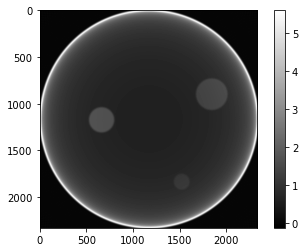

In [97]:
plt.imshow(recon, cmap = 'gray')
plt.colorbar()
plt.show()

In [24]:

gamma

array([-34.963175, -34.933125, -34.903075, ...,  34.963175,  34.993225,
        35.023275])

# Implementation test. 

In [13]:
R = 400 #self.params['SourceToAxis']
D = 400 #self.params['SourceToDetector'] - R
nx = rec.shape[0]
ny = 1
ns = rec.shape[1]
DetectorPixelWidth = 0.0601
ZeroPaddedLength = int(2 ** (np.ceil(np.log2(2 * (nx - 1)))))
#         DetectorPixelWidth = 445.059 / nx;
print(DetectorPixelWidth)
recon = np.zeros((rec.shape[0],rec.shape[0]))

DetectorSize = nx * DetectorPixelWidth

fov = 2 * R * sin(atan(DetectorSize / 2 / (D + R)))
#     self.params['fov'] = fov
x = np.linspace(-fov / 2, fov / 2, rec.shape[0])
y = np.linspace(-fov / 2, fov / 2, rec.shape[0])
[xx, yy] = np.meshgrid(x, y)
[phi, rho] = cart2pol(xx, yy)
#     ReconZ = self.recon.shape[2]

# in radians
ProjectionAngle = np.linspace(0, np.radians(360), ns + 1)
ProjectionAngle = ProjectionAngle[0:-1]
dtheta = ProjectionAngle[1] - ProjectionAngle[0]
print(dtheta)

cutoff = 0.3
# FilterType = 'hamming'
# filter = Filter(rec.shape[0]+ 1, DetectorPixelWidth * (R / (R + D)), FilterType, cutoff)
filter = np.abs(np.linspace(-0.5/DetectorPixelWidth. 0.5/DetectorPixelWidth, nx))
gamma = np.arange(0, nx) - (nx - 1) / 2.0
gamma = gamma * DetectorPixelWidth * (R / (R + D))

weight = R / (sqrt(R ** 2 + gamma ** 2))
#print(weight.shape)

for i in range(0, ns):
    i = 1
    angle = ProjectionAngle[i]
    #print(angle)
    WeightedSino = weight * sino[:,i]
    #print(WeightedSino.shape)
    # need to FFT pad. 
    Q = real(ifft(ifftshift(filter * fftshift(fft(WeightedSino)))))
    #print(Q.shape)

    # understand lin space. 
    t = xx * cos(angle) + yy * sin(angle)
    s = -xx * sin(angle) + yy * cos(angle)
    #print(t.shape)
    InterpX = (R * t) / (R - s)
    U = (D + rho * sin(angle - phi)) / D
    f = interp1d(gamma, Q, kind='linear', bounds_error=False, fill_value=0)
    vq = f(InterpX)
    recon[:,:]+= dtheta * (1 / (U ** 2)) * vq.reshape([recon.shape[0], recon.shape[1]])




0.0601
0.017453292519943295
(2330,) (2330,)


# Remaining. 

In [16]:


sino = self.sino[:, :, j]
weight = R / (sqrt(R ** 2 + gamma ** 2))
for i in range(0, ns):
    angle = ProjectionAngle[i]
    WeightedSino = weight * sino[i, :]
    Q = real(
        ifft(ifftshift(filter * fftshift(fft(WeightedSino, ZeroPaddedLength)))))
    t = xx * cos(angle) + yy * sin(angle)
    s = -xx * sin(angle) + yy * cos(angle)
    InterpX = (R * t) / (R - s)
#                 print(InterpX.max(), InterpX.min(), R)
    U = (D + rho * sin(angle - phi)) / D
    f = interp1d(gamma, Q, kind='linear',
                 bounds_error=False, fill_value=0)
    vq = f(InterpX)
    recon[:, :, j] += dtheta * (1 / (U ** 2)) * vq.reshape(
        [self.params['ReconX'], self.params['ReconY']])

'''
    TO DO: Write file name definition
           Save reconstruction condition
    '''
self.recon = recon.astype(np.float32)
self.recon.tofile(savefile, sep='', format='')
# f = open('condition.txt')
# f.close()

NameError: name 'self' is not defined